In [ ]:
!pip install -U tensorflow-addons

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model

# Make Model

In [ ]:
num_classes = 1000
input_shape = (36, 60, 3)

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 64  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Resizing(image_size, image_size),
    ],
    name="data_augmentation",
)

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

"""
def eye_model():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    return inputs, logits
"""

def eye_model():
  inputs = layers.Input(shape=input_shape)
  resnet = keras.applications.ResNet50(include_top=False,weights=None)(inputs)
  flatten = layers.Flatten()(resnet)
  outs = layers.Dense(512)(flatten)
  return inputs, outs

def landmark_model():
  inputs = layers.Input(shape=(33,))

  fc1 = layers.Dense(128)(inputs)
  batchNorm1 = layers.BatchNormalization(momentum=0.9)(fc1)
  relu1 = layers.ReLU()(batchNorm1)

  fc2 = layers.Dense(16)(relu1)
  batchNorm2 = layers.BatchNormalization(momentum=0.9)(fc2)
  relu2 = layers.ReLU()(batchNorm2)

  fc3 = layers.Dense(16)(relu2)
  batchNorm3 = layers.BatchNormalization(momentum=0.9)(fc3)
  relu3 = layers.ReLU()(batchNorm3)

  return inputs, relu3

def make_model():
  eye_inputs, eye_feat = eye_model()
  lms_inputs, lms_feat = landmark_model()

  # Concatenate
  concat = layers.Concatenate()([eye_feat, lms_feat])

  # combined model
  fc1 = layers.Dense(8)(concat)
  batch_norm1 = layers.BatchNormalization(momentum=0.9)(fc1)
  dropout1 = layers.Dropout(0.12)(batch_norm1)
  relu1 = layers.ReLU()(dropout1)

  fc2 = layers.Dense(8)(relu1)
  batch_norm2 = layers.BatchNormalization(momentum=0.9)(fc2)
  dropout2 = layers.Dropout(0.12)(batch_norm2)
  relu2 = layers.ReLU()(dropout2)

  outs = layers.Dense(3)(relu2)

  model = keras.models.Model(inputs=[eye_inputs, lms_inputs], outputs=outs)

  return model

In [ ]:
model = make_model()

In [ ]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001,momentum=0.9),loss='mse',metrics=['mse'])

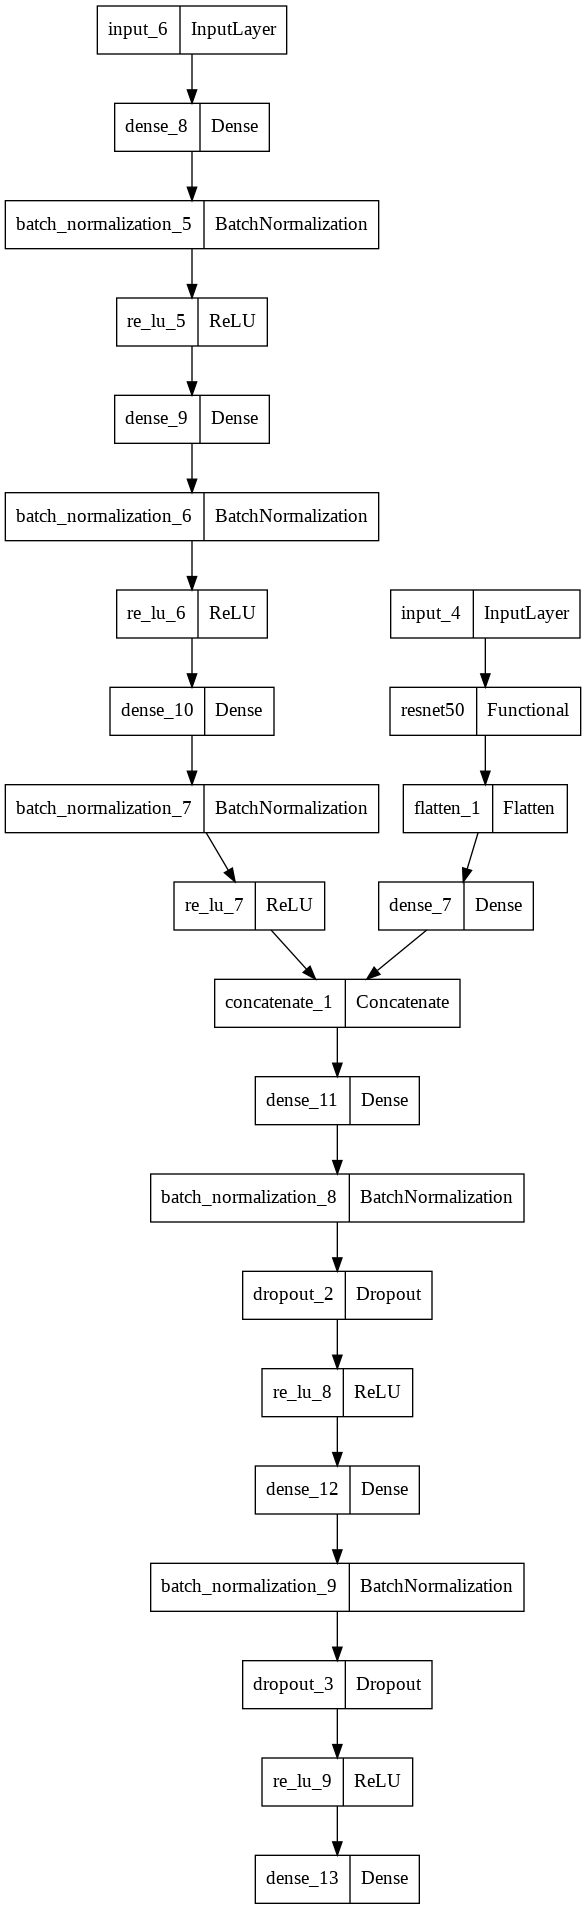

In [ ]:
plot_model(model)

# Train Model

In [ ]:
from copy import deepcopy as dc
import json
import scipy
import scipy.io
from tqdm import tqdm
from sklearn.utils import shuffle
import os
from random import Random

In [ ]:
class Patient:
  def __init__(self,patient):
    self.patient = patient
    self.days = [d for d in os.listdir('/content/drive/MyDrive/GazeMLDetection/Normalized/'+self.patient)]
    self.anns = json.load(open('/content/drive/MyDrive/GazeMLDetection/'+self.patient+'.json'))

  def load(self):
    eyes = None
    anns_set = None

    for day in self.days:
      data = scipy.io.loadmat(dir+f'Normalized/{self.patient}/{day}')['data']

      eyeRight = data[0][0][0][0][0][1]
      eyeLeft = data[0][0][1][0][0][1]

      annsRight = np.hstack([np.array(self.anns[day[:-4]])[:,26:29], np.array(self.anns[day[:-4]])[:,0:24], np.array(self.anns[day[:-4]])[:,29:38]])
      annsLeft = np.hstack([np.array(self.anns[day[:-4]])[:,26:29], np.array(self.anns[day[:-4]])[:,0:24], np.array(self.anns[day[:-4]])[:,29:35], np.array(self.anns[day[:-4]])[:,38:]])

      eyePair = np.vstack([eyeRight,eyeLeft])
      annsPair = np.vstack([annsRight,annsLeft])

      if not isinstance(eyes, np.ndarray):
        eyes = dc(eyePair)
      else:
        eyes = np.vstack([eyes,eyePair])

      if not isinstance(anns_set, np.ndarray):
        anns_set = dc(annsPair)
      else:
        anns_set = np.vstack([anns_set,annsPair])

    return eyes, anns_set

def get_dataset(patients):
  patients = [Patient(p) for p in patients]
  eyes = None
  anns = None
  for patient in tqdm(patients):
    eyeP, annP = patient.load()
    if not isinstance(eyes, np.ndarray):
      eyes = dc(eyeP)
    else:
      eyes = np.vstack([eyes, eyeP])
    if not isinstance(anns, np.ndarray):
      anns = dc(annP)
    else:
      anns = np.vstack([anns, annP])
  eyes, anns = shuffle(eyes, anns)

  lms = anns[:,3:]

  labels = anns[:,:3]

  return Dataset([eyes, lms], labels, batch_size)

In [ ]:
class Dataset(tf.keras.utils.Sequence):
  def __init__(self,x,y,batch_size=16):
    self.eyes, self.lms = x
    self.y = y
    self.batch_size = batch_size
  def __len__(self):
    return int(np.ceil(len(self.y)/self.batch_size))
  def __getitem__(self,i):
    minIdx = self.batch_size*i
    maxIdx = min(self.batch_size*(i+1), len(self.y))

    return [self.tripple_channel(self.eyes[minIdx:maxIdx]),self.lms[minIdx:maxIdx]], self.y[minIdx:maxIdx]

  def tripple_channel(self, arr):
    return np.stack([arr,arr,arr],-1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
dir = '/content/drive/MyDrive/GazeMLDetection/'

In [ ]:
patients = os.listdir(dir+'Normalized')

In [ ]:
Random(42).shuffle(patients)

In [ ]:
patients_train = patients[:11]
patients_val = patients[11:13]
patients_test = patients[13:]

In [ ]:
train_set = get_dataset(patients_train)
val_set = get_dataset(patients_val)
test_set = get_dataset(patients_test)

100%|██████████| 2/2 [00:17<00:00,  8.74s/it]


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    dir+'model_weights.h5', monitor='val_loss',
    save_weights_only=True, mode='auto', save_freq='epoch',
)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.01,patience=10,restore_best_weights=True)

In [ ]:
history = model.fit(x=train_set, batch_size=1,validation_data=val_set,epochs=100,callbacks=[checkpoint,earlystopping])

Epoch 1/100
962/962 [==============================] - 1419s 1s/step - loss: 1813.1622 - mse: 1813.1622 - val_loss: 2819.1233 - val_mse: 2819.1233
Epoch 2/100
962/962 [==============================] - 1407s 1s/step - loss: 1099.6128 - mse: 1099.6128 - val_loss: 2595.7842 - val_mse: 2595.7842
Epoch 3/100
962/962 [==============================] - 1419s 1s/step - loss: 969.6825 - mse: 969.6825 - val_loss: 2613.4941 - val_mse: 2613.4941
Epoch 4/100
962/962 [==============================] - 1423s 1s/step - loss: 909.3640 - mse: 909.3640 - val_loss: 2523.1323 - val_mse: 2523.1323
Epoch 5/100
962/962 [==============================] - 1431s 1s/step - loss: 864.0157 - mse: 864.0157 - val_loss: 2617.1467 - val_mse: 2617.1467
Epoch 6/100
962/962 [==============================] - 1446s 2s/step - loss: 834.6837 - mse: 834.6837 - val_loss: 2573.0986 - val_mse: 2573.0986
Epoch 7/100
962/962 [==============================] - 1435s 1s/step - loss: 805.0986 - mse: 805.0986 - val_loss: 2458.3508 - 

In [ ]:
model.save(dir+"model")

In [ ]:
import json
json.dump(history.history,open(dir+'model_history.json','w'))